#### Week 2: Vector Search Applications w/ LLMs.  Authored by Chris Sanchez.

# Week 2 - Notebook 4

# Overview

Welcome to Week 2 of the course!  We covered a lot of content last week in order to get to the point where we can search over our data.  I hope that you were able to improve upon your initial baseline retrieval score, by tweaking some of your index parameters or swapping out (and/or fine-tuning) your embedding model.  In this notebook, you'll have the chance to improve those scores even further as we take a look at combining the strengths of keyword and vector search using Weaviate's `with_hybrid` method.  We'll also incorporate the use of a CrossEncoder reranker to pack the final punch in our retrieved hits, before we pass those results to the LLM for answer synthesis.  Here's a reminder of where we've been and where we're going:

#### Week One
* ~Part 1:~
  * ~Data ingest and preprocessing~
  * ~Convert text into vectors~
* ~Part 2~:
  * ~Index data on Weaviate database~
  * ~Search over data~
* ~Part 2.5~:
  * ~Benchmark retrieval results~

#### Week Two
* **Part 3 (THIS NOTEBOOK)**:
  * **Add a reranker to the mix (new benchmark)**
* Part 4:
  * Integrate with GPT-Turbo
* Part 5:
  * Display results in Streamlit

#### This notebook will cover the highlighted portion of the technical diagram below, as initially referenced in the Course content:

![arch diagram]( 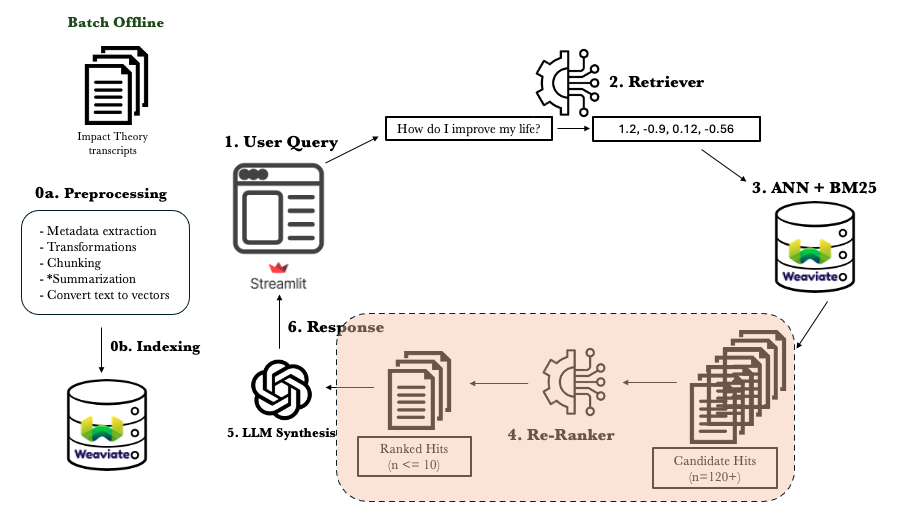)

In [1]:
%load_ext autoreload 
%autoreload 2
    
#standard python
from typing import List, Union, Dict, Tuple
import os
from torch.nn import Sigmoid

# external libraries
from sentence_transformers import CrossEncoder, SentenceTransformer
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from loguru import logger
from rich import print  # nice library that provides improved printing output (overrides default print function)

# external files
from reranker import ReRanker
from preprocessing import FileIO
from weaviate_interface import WeaviateClient

#load from local .env file
from dotenv import load_dotenv, find_dotenv
env = load_dotenv('.env', override=True)

## Setup 
***

### Instantiate Weaviate Client

In [2]:
#read env vars from local .env file
api_key = os.environ['WEAVIATE_API_KEY']
url = os.environ['WEAVIATE_ENDPOINT']

#instantiate client
client = WeaviateClient(api_key, url, model_name_or_path='./models/finetuned-all-MiniLM-L6-v2-300')

#check if WCS instance is live and ready
client.is_live(), client.is_ready()

(True, True)

In [3]:
#display available class names on cluster
available_classes = sorted([c['class'] for c in client.schema.get()['classes']])
print(available_classes)

['Impact_theory_minilm_256', 'Impact_theory_minilm_256_finetuned']

In [4]:
#set class name to run queries on
class_name = "Impact_theory_minilm_256_finetuned"

In [5]:
print(client.show_class_config(class_name))

{
    'class': 'Impact_theory_minilm_256_finetuned',
    'description': 'Episodes of Impact Theory up to Nov 2023',
    'invertedIndexConfig': {
        'bm25': {'b': 0.75, 'k1': 1.2},
        'cleanupIntervalSeconds': 60,
        'stopwords': {'additions': None, 'preset': 'en', 'removals': None}
    },
    'multiTenancyConfig': {'enabled': False},
    'properties': [
        {
            'dataType': ['text'],
            'indexFilterable': True,
            'indexSearchable': True,
            'name': 'title',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': True,
            'indexSearchable': False,
            'name': 'video_id',
            'tokenization': 'word'
        },
        {'dataType': ['int'], 'indexFilterable': True, 'indexSearchable': False, 'name': 'length'},
        {
            'dataType': ['text'],
            'indexFilterable': False,
            'indexSearchable': False,
            'name': 'thumbnail_url',
            'tokenization': 'word'
        },
        {'dataType': ['int'], 'indexFilterable': True, 'indexSearchable': False, 'name': 'views'},
        {
            'dataType': ['text'],
            'indexFilterable': False,
            'indexSearchable': False,
            'name': 'episode_url',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': True,
            'indexSearchable': False,
            'name': 'doc_id',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': True,
            'indexSearchable': True,
            'name': 'guest',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': False,
            'indexSearchable': True,
            'name': 'summary',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'indexFilterable': False,
            'indexSearchable': True,
            'name': 'content',
            'tokenization': 'word'
        },
        {
            'dataType': ['text'],
            'description': "This property was generated by Weaviate's auto-schema feature on Sat Dec 23 16:09:59 
2023",
            'indexFilterable': True,
            'indexSearchable': True,
            'name': 'playlist_id',
            'tokenization': 'word'
        }
    ],
    'replicationConfig': {'factor': 1},
    'shardingConfig': {
        'virtualPerPhysical': 128,
        'desiredCount': 1,
        'actualCount': 1,
        'desiredVirtualCount': 128,
        'actualVirtualCount': 128,
        'key': '_id',
        'strategy': 'hash',
        'function': 'murmur3'
    },
    'vectorIndexConfig': {
        'skip': False,
        'cleanupIntervalSeconds': 300,
        'maxConnections': 32,
        'efConstruction': 128,
        'ef': 64,
        'dynamicEfMin': 100,
        'dynamicEfMax': 500,
        'dynamicEfFactor': 8,
        'vectorCacheMaxObjects': 1000000000000,
        'flatSearchCutoff': 40000,
        'distance': 'cosine',
        'pq': {
            'enabled': False,
            'bitCompression': False,
            'segments': 0,
            'centroids': 256,
            'trainingLimit': 100000,
            'encoder': {'type': 'kmeans', 'distribution': 'log-normal'}
        }
    },
    'vectorIndexType': 'hnsw',
    'vectorizer': 'none'
}

## Discussion  

Hybrid search does just what it sounds like: it combines a keyword search with a vector search, which has the effect of combining the strengths of each method for improved retrieval.  If you'll recall, the initial vector retrieval results we saw with our out-of-the-box `miniLM` model were very poor, compared to the keyword results. You should have seen a `kw_hit_rate` of `.72` and a `vector_hit_rate` of a dismal `.37`: 

```
{'n': 5,
 'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
 'chunk_size': 256,
 'kw_hit_rate': 0.72,
 'kw_mrr': 0.59,
 'vector_hit_rate': 0.37,
 'vector_mrr': 0.29,
 'total_misses': 25,
 'total_questions': 100,
 'maxConnections': 64,
 'efConstruction': 128,
 'ef': 400}
```
You may also have noticed that the `total_misses` score was `25`, meaning that neither method picked up the golden `doc_id` in the "n" retrieved results, a total of 25 times.  From another perspective, it means that between keyword and vector search, they found 75 out of 100 of the golden `doc_ids`.  So if 75 docs were found then how come we don't see a hit rate score of 75 in one of the two methods....?

If you compare the total misses with the keyword hit rate (the highest scoring method), you'll see that keyword picked up 72 of the correct docs, but the combined results picked up 75.  We can interpret this to mean that the vector search method accounts for the difference of 3 hits between the keyword hit rate and the total of 75 correct documents found.  Combining these two methods through hybrid search allows us to close this gap. 

# Hybrid Search - `RelativeRankFusion`  
If you recall from the [Course Notes](https://uplimit.com/course/vector-search-apps/v2/enrollment/enrollment_clnnpb75t000j1aabfiqp1p9p/module/module_cloyt58n600001356gbbefg4b), Weaviates Hybrid search method uses the `RelativeRankFusion` algorithm under the hood. Combining keyword and vector search scores is an area of active research, so the algorithm used by Weaviate is "a" way to perform hybrid search, not "the" way. Let's walk through the steps at a high level and then break it down in code:
1. Execute a keyword and a vector search and get the raw scores and doc_ids of each.
2. Normalize scores between 0 and 1 relative to each method.
3. Multiply the normalized scores by a weighted value: `alpha`.
4. Add scores together that both have the same `doc_id`.
5. Combine search results together in ranked order according to score values. 

### Get responses to query

In [6]:
query = 'How will listening to Impact Theory improve your life'

In [7]:
kw_response = client.keyword_search(query, class_name, limit=10)
vector_response = client.vector_search(query, class_name, limit=10)

### Extract scores and doc_ids

In [8]:
from collections import OrderedDict, defaultdict

def get_scores_ids(response: List[dict], include_cross_score: bool=False):
    '''
    Extracts scores and ids from response object.
    If keyword, extracts from "score" field.
    If vector, extracts from "distance" field and 
    subtracts from 1 in keeping with the concept that
    higher scores are better. 
    '''
    def round_float(score: str, place: int=3):
        return round(float(score),place)
        
    score_dict = OrderedDict()
    if response[0].get('score'):
        if include_cross_score: 
            return {d['doc_id'] : f'Score: {round_float(d["score"])}   :   Cross-Score: {round_float(d["cross_score"])}' for d in response}
        return {d['doc_id'] : d['score'] for d in response}
    return {d['doc_id'] : 1 - d['distance'] for d in response}

### Raw scores
Using the above function we're going to pull out the `doc_ids` and the raw (unnormalized) scores from each search method. Note the difference in score magnitude between BM24 ranking and the Cosine score.

In [9]:
kw_scores = get_scores_ids(kw_response)
vec_scores = get_scores_ids(vector_response)
kw_scores, vec_scores

({'kE3yryW-FiE_25': '7.9831176',
  'C9aqGqjC1kE_18': '7.7555885',
  '_2ZK9Y7QSmU_20': '7.6482215',
  'l4fLax7S2Q0_66': '7.47961',
  'WQyg2vPuOn4_54': '7.157775',
  'IQefdkl8PfY_54': '6.9711',
  '9aRy7DZ0Ek4_67': '6.9168468',
  'XGOUzDUm4C4_37': '6.729196',
  'Dzlg17y0IMM_62': '6.597884',
  'FZ246h-C8p8_67': '6.563054'},
 {'IQefdkl8PfY_54': 0.6841111200000001,
  'kE3yryW-FiE_25': 0.64558733,
  'Or7CFDgfEYI_21': 0.63788676,
  'C9aqGqjC1kE_18': 0.6272214700000001,
  '_2ZK9Y7QSmU_20': 0.62621772,
  'l4fLax7S2Q0_66': 0.6242133999999999,
  'Dzlg17y0IMM_62': 0.6000743,
  '_vJ4DSjT7IM_1': 0.58625573,
  'le8CaFQsIGk_28': 0.5351912999999999,
  'SPkCj1TK4fg_39': 0.53311497})

### Normalize scores relative to each method
Normalize all scores so that the values are between 0 and 1 relative to one other **within** each method.  In other words we are normalizing scores for each method, not normalizing across all scores, because this will not work in practice given that a BM25 score has no meaning relative to a Cosine Similarity score.  

In [10]:
#using sklearn to normalize scores
from sklearn.preprocessing import MinMaxScaler
from numpy import ndarray

scaler = MinMaxScaler()
kw_normal = scaler.fit_transform([[score] for score in kw_scores.values()])
vec_normal = scaler.fit_transform([[score] for score in vec_scores.values()])
kw_normal, vec_normal

(array([[1.        ],
        [0.83977542],
        [0.76416824],
        [0.64543306],
        [0.41879885],
        [0.28734347],
        [0.2491387 ],
        [0.11699617],
        [0.02452707],
        [0.        ]]),
 array([[1.        ],
        [0.74486906],
        [0.69387061],
        [0.62323774],
        [0.61659022],
        [0.60331624],
        [0.44345058],
        [0.35193454],
        [0.01375088],
        [0.        ]]))

### Multiply by weighted alpha value

Weight the values by multiplying by the `alpha` parameter. `alpha` is an indication of how strong we want to weight the scores toward vector search.  Setting `alpha` to 0 results in a pure keyword search (vector scores will be multiplied by 0, meaning they won't be considered as part of the search results) and setting `alpha` to 1 results in a pure vector-based search. For this example we'll set `alpha` to `0.45` meaning we'll multiply the vector scores by `0.45` (thus diminishing their importance to the returned results) and multiply the keyword scores by `0.55` (boosting their importance to the returned results).  

In [11]:
alpha = 0.45
kw_weighted = kw_normal * (1 - alpha)
vec_weighted = vec_normal * alpha
kw_weighted, vec_weighted

(array([[0.55      ],
        [0.46187648],
        [0.42029253],
        [0.35498819],
        [0.23033937],
        [0.15803891],
        [0.13702629],
        [0.06434789],
        [0.01348989],
        [0.        ]]),
 array([[0.45      ],
        [0.33519108],
        [0.31224177],
        [0.28045699],
        [0.2774656 ],
        [0.27149231],
        [0.19955276],
        [0.15837054],
        [0.0061879 ],
        [0.        ]]))

### Update final scores

After intra-method normalization and score weighting, we can now update our docs with their new scores.  One more step to complete is to add together any scores coming from the same document in both results.  This should make intuitive sense, we want to boost the scores of documents that **both** methods picked up.  

In [12]:
def update_scores(weighted_kw_scores: ndarray, weighted_vec_scores: ndarray) -> None:
    for i, k in enumerate(kw_scores):
        kw_scores[k] = weighted_kw_scores[i][0]
    for i, k in enumerate(vec_scores):
        vec_scores[k] = weighted_vec_scores[i][0]

In [13]:
update_scores(kw_weighted, vec_weighted)

#the updated scores should look very different from their original raw scores
kw_scores, vec_scores

({'kE3yryW-FiE_25': 0.5500000000000005,
  'C9aqGqjC1kE_18': 0.4618764786309573,
  '_2ZK9Y7QSmU_20': 0.4202925312640928,
  'l4fLax7S2Q0_66': 0.3549881850362196,
  'WQyg2vPuOn4_54': 0.23033936649034617,
  'IQefdkl8PfY_54': 0.15803890755315467,
  '9aRy7DZ0Ek4_67': 0.13702628530158828,
  'XGOUzDUm4C4_37': 0.06434789258734637,
  'Dzlg17y0IMM_62': 0.013489888762728698,
  'FZ246h-C8p8_67': 0.0},
 {'IQefdkl8PfY_54': 0.45000000000000023,
  'kE3yryW-FiE_25': 0.3351910760638599,
  'Or7CFDgfEYI_21': 0.3122417723895609,
  'C9aqGqjC1kE_18': 0.28045698516154216,
  '_2ZK9Y7QSmU_20': 0.27746560094412986,
  'l4fLax7S2Q0_66': 0.2714923095721314,
  'Dzlg17y0IMM_62': 0.19955276012004267,
  '_vJ4DSjT7IM_1': 0.15837054123565406,
  'le8CaFQsIGk_28': 0.006187896181458807,
  'SPkCj1TK4fg_39': 0.0})

### Add together any documents with the same doc_id and then sort final results

In [14]:
def add_doc_scores(kw_scores: Dict[str, float], 
                   vec_scores: Dict[str, float],
                   top_k: int=5
                  ) -> List[Tuple[str, float]]:
    '''
    Combined keyword and vector scores by adding values 
    for any duplicate docs and then sorts resulting 
    dictionary of results.  Returns top_k values. 
    '''
    hybrid_results = kw_scores
    for k,value in vec_scores.items():
        if k in kw_scores:
            hybrid_results[k] += value
        else:
            hybrid_results[k] = value
    return sorted(hybrid_results.items(), key=lambda x: x[1], reverse=True)[:top_k]

In [15]:
# #compare these final ranked value with the original keyword and vector queries
ranked_results = add_doc_scores(kw_scores, vec_scores, top_k=5)
ranked_results

[('kE3yryW-FiE_25', 0.8851910760638604),
 ('C9aqGqjC1kE_18', 0.7423334637924994),
 ('_2ZK9Y7QSmU_20', 0.6977581322082227),
 ('l4fLax7S2Q0_66', 0.626480494608351),
 ('IQefdkl8PfY_54', 0.6080389075531549)]

### Compare manually generated scores with Weaviate hybrid method

In [16]:
#scores and ranking are slightly off due to the way that keyword results are processed
#take a look at one of the 'explainScore' keys for one of the resuls in the hyb_response i.e. hyb_response[0]['explainScore']

hyb_response = client.hybrid_search(query, class_name, alpha=alpha, limit=5)
get_scores_ids(hyb_response), ranked_results

({'kE3yryW-FiE_25': '0.9337709',
  'C9aqGqjC1kE_18': '0.8668575',
  '_2ZK9Y7QSmU_20': '0.8484559',
  'IQefdkl8PfY_54': '0.8428158',
  'l4fLax7S2Q0_66': '0.8188218'},
 [('kE3yryW-FiE_25', 0.8851910760638604),
  ('C9aqGqjC1kE_18', 0.7423334637924994),
  ('_2ZK9Y7QSmU_20', 0.6977581322082227),
  ('l4fLax7S2Q0_66', 0.626480494608351),
  ('IQefdkl8PfY_54', 0.6080389075531549)])

# Assignment 2.1 - Build a Hybrid Search method
***
**Implement a hybrid search method on the Weaviate python client**. 

#### Instructions:
- Fill in the areas of the code wherever you see a `None` statement.
- Compare execution of your code with the results from a `client.hybrid_search` search.  They should match exactly, assuming all params are held constant (including your embedding model).

In [17]:
#################
##  START CODE ##
#################

#configure search constants
embedding_model = client.model
class_name = "Impact_theory_minilm_256"
query = query
query_embedding = client.model.encode(query)
display_properties = ['title', 'video_id', 'length', 'thumbnail_url', 'views', 'episode_url', 'doc_id', 'guest', 'content'] 
properties = ["content"]

#design hybird search query
'''
Get objects using bm25 and vector, then combine the results using a relative fusion ranking algorithm.

Args
----
query: str
    User query.
class_name: str
    Class (index) to search.
display_properties: List[str]=None
    List of properties to return in response.
    If None, returns all properties.
properties: List[str]
    List of properties to search across (using BM25)
alpha: float=0.5
    Weighting factor for BM25 and Vector search.
    alpha can be any number from 0 to 1, defaulting to 0.5:
        alpha = 0 executes a pure keyword search method (BM25)
        alpha = 0.5 weighs the BM25 and vector methods evenly
        alpha = 1 executes a pure vector search method
vector: List[float]
    User query embedding.
limit: int=10
    Number of results to return.

'''

response = (client.query
            .get(class_name=class_name,
                 properties=display_properties)  #reminder that the properties param here refers to the "display_properties"
            # use near_vector our search method, and only search over the "content" property
            .with_hybrid(query=query,
                         alpha=0.45,
                         vector=query_embedding,  # to compare against the embeddings representing the "content" property
                         properties=properties,  # NOT the display_properties, these are the properties that will use BM25 for search
                         fusion_type='relativeScoreFusion')

            # instead of "score", vector search returns a "distance" property for scoring, the smaller the distance, the more semantically similar is the result
            .with_additional(['score', 'distance', 'explainScore'])

            # limit the returned results to the top-3 ranked hits
            .with_limit(3)
#################
##  END CODE   ##
#################
            # execute the search with the "do" command
            .do()
            )

In [18]:
# To show cleaned up results we'll use the built-in format response method
print(client.format_response(response, class_name))

[
    {
        'content': "It's Tom bill you and if you're anything like me You're always looking for ways to level up 
your mindset your business and your life in general That's exactly why I started impact theory a podcast that 
brings together the world's most Successful and inspiring people to share their stories and most importantly 
strategies for success And now it's easier than ever to listen to impact theory on Amazon music Whether you're on 
the go or chilling at home You can simply open up the Amazon music app and search for impact theory with Tom bill 
you to start listening Right away if you really want to take things to the next level just ask Alexa Hey Alexa play
impact theory with Tom bill you on Amazon music Now playing impact theory with Tom bill you on Amazon music and 
boom you're instantly plugged in to the latest and greatest conversations on mindset health Finances and 
entrepreneurship get inspired get motivated and be legendary with impact theory on Amazon music.",
        'doc_id': 'kE3yryW-FiE_25',
        'episode_url': 'https://www.youtube.com/watch?v=kE3yryW-FiE&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
        'guest': 'Tim Urban',
        'length': 10209,
        'thumbnail_url': 'https://i.ytimg.com/vi/kE3yryW-FiE/hq720.jpg',
        'title': 'TOXIC THINKING: How Our Primitive Brain Is FLAWED & Leads To Dangerous Woke Ideology | Tim 
Urban',
        'video_id': 'kE3yryW-FiE',
        'views': 40794,
        'distance': None,
        'explainScore': "(Result Set 'vector') Document b39cd038-9730-4003-b74f-c6f4befb06a6: original score 
0.6455873, normalized score: 0.3837709 - (Result Set 'keyword') Document b39cd038-9730-4003-b74f-c6f4befb06a6: 
original score 7.9831176, normalized score: 0.55",
        'score': '0.9337709'
    },
    {
        'content': "What's up guys, it's Tom Bilyeu, and if you're anything like me, you're always looking for ways
to level up your mindset, your business, and your life in general. That's exactly why I started Impact Theory, a 
podcast that brings together the world's most successful and inspiring people to share their stories and most 
importantly, strategies for success. And now it's easier than ever to listen to Impact Theory on Amazon Music. 
Whether you're on the go or chilling at home, you can simply open up the Amazon Music app and search for Impact 
Theory with Tom Bilyeu to start listening right away. If you really wanna take things to the next level, just ask 
Alexa, hey Alexa, play Impact Theory with Tom Bilyeu on Amazon Music. Now playing Impact Theory with Tom Bilyeu on 
Amazon Music. And boom, you're instantly plugged in to the latest and greatest conversations on mindset, health, 
finances, and entrepreneurship. Get inspired, get motivated, and be legendary with Impact Theory on Amazon Music. 
Let's do this. Or do I actually need the presence of phthalates specifically? No, it's not the phthalate.",
        'doc_id': 'C9aqGqjC1kE_18',
        'episode_url': 'https://www.youtube.com/watch?v=C9aqGqjC1kE&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
        'guest': 'Shanna Swan',
        'length': 7295,
        'thumbnail_url': 'https://i.ytimg.com/vi/C9aqGqjC1kE/hq720.jpg',
        'title': 'POPULATION COLLAPSE: How Modern Life Is Making Men & Women INFERTILE | Shanna Swan',
        'video_id': 'C9aqGqjC1kE',
        'views': 263290,
        'distance': None,
        'explainScore': "(Result Set 'vector') Document 8280f7ab-19bb-4674-9632-9cdc36d73caf: original score 
0.62722147, normalized score: 0.3521968 - (Result Set 'keyword') Document 8280f7ab-19bb-4674-9632-9cdc36d73caf: 
original score 7.7555885, normalized score: 0.5146607",
        'score': '0.8668575'
    },
    {
        'content': "And if you're anything like me, you're always looking for ways to level up your mindset, your 
business and your life in general. That's exactly why I started Impact Theory, a podcast that brings together the 
world's most successful and inspiring people to share

##### To test if your hybrid search implementation is correct, execute the same query using the `client.hybrid_search` method. Compare results.  They should be exactly the same, assuming param values are the same from both methods (make sure to check the default args on the `hybrid_search` method). 

In [19]:
client_response = client.hybrid_search(query, class_name="Impact_theory_minilm_256_finetuned", limit=3)
client_response

[{'content': "It's Tom bill you and if you're anything like me You're always looking for ways to level up your mindset your business and your life in general That's exactly why I started impact theory a podcast that brings together the world's most Successful and inspiring people to share their stories and most importantly strategies for success And now it's easier than ever to listen to impact theory on Amazon music Whether you're on the go or chilling at home You can simply open up the Amazon music app and search for impact theory with Tom bill you to start listening Right away if you really want to take things to the next level just ask Alexa Hey Alexa play impact theory with Tom bill you on Amazon music Now playing impact theory with Tom bill you on Amazon music and boom you're instantly plugged in to the latest and greatest conversations on mindset health Finances and entrepreneurship get inspired get motivated and be legendary with impact theory on Amazon music.",
  'doc_id': 'kE

# Reranking with CrossEncoders
***

Referring to the system architecture diagram above, we'll now address the 2nd Stage Reranking phase.  During this step we'll take the pool of candidate hits collected from the broad "cast of the net" from the 1st Stage Retrieval embedding model and narrow them down to a (hopefully) highly relevant set of results, before passing on to the LLM model for answer synthesis.

### Discussion

We're going to slightly transition away from the way we've been thinking about Retrieval up until this point.  Until now we've been focusing on improving our retrieval results by getting as many document "hits" as possible while keeping our `n` or `limit` value as low as possible.  We could easily improve our `hit_rate` by increasing the size of our net i.e. increase the `limit` value from 5 to 25 or more.  But, we're in the quality business, and we want to make sure that we are only passing on quality results (context) to the LLM model, for three primary reasons:

1. We care about the quality of the answers of the LLM.  LLM answer quality is direcly correlated with context quality.
2. Tokens cost money.  The more tokens, the higher the cost.  Why send ten quality results when only 5, or maybe 3, will get the job done?
3. LLM max context input length.  This is less of a concern than the first two reasons; however, depending on your use case and the size of the context you are feeding the LLM this may become a limiting factor.  If it does, you want to ensure that you are using your context window to it's highest potential i.e. not filling it with garbage search results.

CrossEncoder models, because of their higher accuracy in measuring the semantic similarity between texts, relative to their Bi-Encoder model (embedding model) counterparts, are well-suited for search results reranking.  They excel at bringing the most relevant (semantically similiar) results to the top of the search stack.  As you'll see in the code in the next section, highly relevant results that may have gotten ranked lower due to Bi-Encoder model inaccuracies can be resurfaced through CrossEncoder reranking.  This reranking doesn't come without a cost though. CrossEncoder inference is much more computationaly expensive than Bi-Encoder inference.  The name of the game, therefore, now becomes how big can we make our net (`limit` value) without making it too big that it starts to negatively impact latency of returned results.  So instead of setting the initial `limit` value to 5, we'll cast a big net and set it to 150-200 and then use the CrossEncoder to narrow those results down to 5 (or 3 depending on what our goal is).  Let's see how this works in practice.  

### Instantiate ReRanker

In [20]:
#pass in model_id like any other HuggingFace model
reranker = ReRanker(model_name='BAAI/bge-reranker-base')

### Execute Search

** **Going forward all of our searches will be hybrid with alpha = 0.25**

In [21]:
# re-initialize class_name if needed 
class_name = "Impact_theory_minilm_256_finetuned"

query = 'what life lessons can be learned from the Impact Theory'

In [22]:
# get search results
display_properties = ['content', 'doc_id']
results = client.hybrid_search(query, class_name, display_properties=display_properties, alpha=0.25)

Let's take a look at what how our initial results stack up.  
These were my initial results, they may be different from yours: 
```
{'W7PV8n_QgJY_0': '0.75',
 'YfqwYvMzYYo_0': '0.6763922',
 'Zetsm0aTdME_35': '0.59487736',
 'WYwEshFgDVU_113': '0.5788979',
 'xftOwi3Hstg_41': '0.541939',
 '78I9dTB9vqM_50': '0.4412257',
 'l4fLax7S2Q0_66': '0.43007854',
 'FZ246h-C8p8_67': '0.4053171',
 'wxKVYiNIKZk_52': '0.3814038',
 'kE3yryW-FiE_25': '0.37959677'}
```

In [23]:
get_scores_ids(results, include_cross_score=False)

{'W7PV8n_QgJY_0': '0.75',
 'YfqwYvMzYYo_0': '0.6763922',
 'Zetsm0aTdME_35': '0.59487736',
 'WYwEshFgDVU_113': '0.5788979',
 'xftOwi3Hstg_41': '0.541939',
 '78I9dTB9vqM_50': '0.4412257',
 'l4fLax7S2Q0_66': '0.39559725',
 '_2ZK9Y7QSmU_20': '0.38355893',
 'wxKVYiNIKZk_52': '0.3814038',
 'kXQNXI0CVtw_16': '0.35266855'}

### Rerank results

Now let's use our ReRanker to rerank the above results and see what we get.  By default, the ReRanker version we are using here, will pass the model logits through a Sigmoid activation function in order to display the score as values between 0 and 1.  I find it more explainable to read the scores this way.  Feel free to change the `apply_sigmoid` param to `False` if you want to see the raw logits.  In any case, each result in the `results` variable will be rescored and a new `cross_score` key will be added to keep track of the new scoring. 

In [24]:
# initial result before reranking step
results[0]

{'content': "We've had the great fortune of featuring some truly extraordinary women on Impact Theory, and in this very special episode, we'll share some of the most powerful lessons they've learned on their journey to success. These inspiring women have exceeded what the world has told them they can be and achieve, and whether we're talking about an athlete like Keri Walsh Jennings, a business magnet like Sarah Robohagen, or an inspirational powerhouse like Mel Robbins, each of these women have stories worth telling and lessons worth listening to really, really closely. And if you want to succeed, whether in business or in life, pay attention. I know I did. Good to have you on the show. Oh my gosh. Thank you. Absolutely. You know, you called me the master of motivation, and I think motivation is complete garbage, so maybe we should start there. That is a perfect place to start, so I totally agree with you. But why do you say that? You do? I do, 100%. Now, I said that in the spirit of,

In [25]:
reranked = reranker.rerank(results, query, apply_sigmoid=True)

##### Notice the addition of the cross_score key after reranking

In [26]:
reranked[0]

{'content': "Hey, everybody. Tom here. Quick question. Are you enjoying today's episode? Certainly hope so. If you are, here's the deal. Today's class is a preview of a workshop that I gave from Impact Theory University called How to Own Your Life. Over the last few months and years, I have to imagine all of us have been given a lot of valid reasons to stop chasing our goals and dreams and give up ownership of our future. It's a pretty weird time, but like I said at the start of this workshop, life is brutally tough and you're going to be tested over and over again. The lessons and tactics you're learning right now are going to be needed now more than ever. In this free preview here, I'm giving you the first five strategies to truly take ownership of your life. And if you want to get free access to the second half of this workshop, you can register to watch part two at ownyourlife.impacttheory.com or just click the link in the description. When you do, I'll also send you the worksheet 

### Under the Hood

Under the hood, the CrossEncoder model reranks the results by taking in as input each result `'content'` paired with the original `query`.  The model then produces a similarity score for each pair.  That score is assigned back to the result that it came from and the final results are reranked according to the new `cross_score` field and returned.  Finally, let's take a look at the practical impact on the results. These are my results, post-reranking:
```
{'W7PV8n_QgJY_0': 'Score: 0.75   :   Cross-Score: 0.993',
 'FZ246h-C8p8_67': 'Score: 0.405   :   Cross-Score: 0.97',
 'WYwEshFgDVU_113': 'Score: 0.579   :   Cross-Score: 0.899',
 'l4fLax7S2Q0_66': 'Score: 0.43   :   Cross-Score: 0.849',
 'kE3yryW-FiE_25': 'Score: 0.38   :   Cross-Score: 0.814',
 'YfqwYvMzYYo_0': 'Score: 0.676   :   Cross-Score: 0.744',
 '78I9dTB9vqM_50': 'Score: 0.441   :   Cross-Score: 0.079',
 'wxKVYiNIKZk_52': 'Score: 0.381   :   Cross-Score: 0.058',
 'Zetsm0aTdME_35': 'Score: 0.595   :   Cross-Score: 0.04',
 'xftOwi3Hstg_41': 'Score: 0.542   :   Cross-Score: 0.005'}
```
<div class="alert alert-danger"><h5>Your results may vary from mine, depending on which embedding model you are using.  The important point to note is that the ReRanker will rearrange the results due to higher accuracy with semantic similarity.</h5></div>

In [27]:
get_scores_ids(reranked, include_cross_score=True)

{'kXQNXI0CVtw_16': 'Score: 0.353   :   Cross-Score: 0.975',
 'WYwEshFgDVU_113': 'Score: 0.579   :   Cross-Score: 0.919',
 'W7PV8n_QgJY_0': 'Score: 0.75   :   Cross-Score: 0.861',
 'YfqwYvMzYYo_0': 'Score: 0.676   :   Cross-Score: 0.55',
 '_2ZK9Y7QSmU_20': 'Score: 0.384   :   Cross-Score: 0.497',
 'l4fLax7S2Q0_66': 'Score: 0.396   :   Cross-Score: 0.488',
 'wxKVYiNIKZk_52': 'Score: 0.381   :   Cross-Score: 0.129',
 '78I9dTB9vqM_50': 'Score: 0.441   :   Cross-Score: 0.07',
 'xftOwi3Hstg_41': 'Score: 0.542   :   Cross-Score: 0.006',
 'Zetsm0aTdME_35': 'Score: 0.595   :   Cross-Score: 0.003'}

A cursory analysis of the above readout shows that only 2 of the original Top Five retrieved results are still in the Top Five after being reranked.  Documents `YfqwYvMzYYo_0`, `Zetsm0aTdME_35`, and `xftOwi3Hstg_41` have all dropped from their original place of 2, 3, and 5 respectively, and shifted down to places 6, 9, and 10.  Something else to note is that the CrossEncoder "feels" strongly that the top three results are where they should be, considering their values are all `>= 0.9`. This is the power of CrossEncoders.  They can find the hidden "diamonds in the rough" and surface them to their rightful place in the stack rankings.  But don't take my word for it try a few searches for yourself and see what the results look like, I encourage you to also increase the `limit` parameter to see how deep the [Rabbit Hole](https://en.wikipedia.org/wiki/Down_the_rabbit_hole) goes.  

<div class="alert alert-success"><h5>Pause here and take a moment running different searches and comparing the results both before and after the reranking step. Take all the time you need to convince yourself that a ReRanker will be useful for the application you're building</h5></div>

# Evaluation of Reranker Effect on Latency

Before moving on to the final Assignment for this notebook, it's worth pausing to note that it's not all sunshine and roses when using a CrossEncoder.  
For an illustration of the effects that increasing the size of `n` has on latency, execute the following cell and draw your own conclusions. 

Search: No Reranker:   0%|          | 0/29 [00:00<?, ?it/s]

Search: With Reranker:   0%|          | 0/29 [00:00<?, ?it/s]

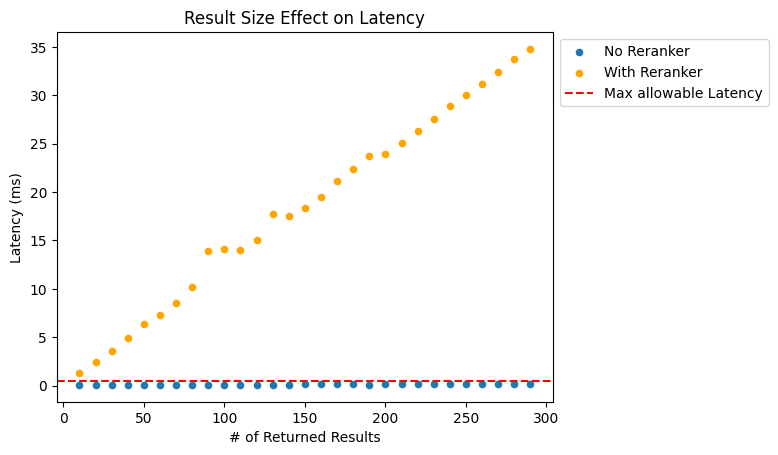

In [28]:
import time
import pandas as pd

def time_search(client: WeaviateClient, 
                class_name: str,
                limit: int,
                rerank: bool
                ) -> float:
    '''
    Executes search given a limit value. 
    Returns total time in seconds
    '''
    query = 'how do I make a million dollars'
    start = time.perf_counter()
    response = client.hybrid_search(query, class_name, limit=limit, display_properties=['content', 'title'])
    if rerank:
        reranked = reranker.rerank(response, query)
    end = time.perf_counter() - start
    return round(end, 3)

limit_values = list(range(10, 300, 10))

unranked_times = []
for n in tqdm(limit_values, 'Search: No Reranker'):
    unranked_times.append((time_search(client, class_name, limit=n, rerank=False), n))
    

ranked_times = []
for n in tqdm(limit_values, 'Search: With Reranker'):
    ranked_times.append((time_search(client, class_name, limit=n, rerank=True), n))



unranked = pd.DataFrame(unranked_times, columns=['time', 'n'])
ranked = pd.DataFrame(ranked_times, columns=['time', 'n'])

ax = unranked.plot.scatter(x='n', y='time', label='No Reranker', title='Result Size Effect on Latency')
ax2 = ranked.plot.scatter(x='n', y='time', ax=ax, color='orange', ylabel='Latency (ms)', label='With Reranker', xlabel='# of Returned Results')
hline = ax2.axhline(y = 0.5, color = 'r', linestyle = 'dashed', label = "Max allowable Latency")     
legend = ax2.legend(bbox_to_anchor = (1.0, 1)) 

# Assignment 2.2 - New Retrieval Benchmark
***
**Reevaluate your retrieval results, this time using hybrid search and a Reranker** 

#### Instructions:
- Fill in the areas of the code wherever you see a `None` statement.  Use the `execute_evaluation` function to run your retrieval benchmark.
- `execute_evaluation` is the same function from Notebook 3, albeit with some modifications to incorporate hybrid search and Reranker functionality.  

In [29]:
from retrieval_evaluation import execute_evaluation
from llama_index.finetuning import EmbeddingQAFinetuneDataset

golden_dataset = EmbeddingQAFinetuneDataset.from_json('./data/golden_100.json')

#################
##  START CODE ##
#################

retrieval_results = execute_evaluation(dataset=golden_dataset,
                                       class_name='Impact_theory_minilm_256_finetuned',
                                       retriever=client)

#################
##  END CODE   ##
#################


/Users/dmr/miniforge3/envs/vector-search-w-llm/lib/python3.10/site-packages/llama_index/download/download_utils.py:11: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/dmr/miniforge3/envs/vector-search-w-llm/lib/python3.10/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
Queries: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]

Total Processing Time: 0.45 minutes


In [30]:
retrieval_results

{'n': 100,
 'top_k': 5,
 'alpha': 0.5,
 'Retriever': './models/finetuned-all-MiniLM-L6-v2-300',
 'Ranker': 'None',
 'chunk_size': 256,
 'kw_hit_rate': 0.72,
 'kw_mrr': 0.59,
 'vector_hit_rate': 0.46,
 'vector_mrr': 0.33,
 'hybrid_hit_rate': 0.73,
 'hybrid_mrr': 0.59,
 'total_misses': 18,
 'total_questions': 100,
 'maxConnections': 32,
 'efConstruction': 128,
 'ef': 64}

In [31]:
retrieval_results_ = execute_evaluation(dataset=golden_dataset, 
                                        class_name='Impact_theory_minilm_256_finetuned', 
                                        retriever=client, 
                                        reranker=reranker,
                                        alpha=0.5,
                                        retrieve_limit=100,
                                        top_k=5)

Queries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:14:08<00:00, 44.48s/it]

Total Processing Time: 74.13 minutes


In [32]:
retrieval_results_

{'n': 100,
 'top_k': 5,
 'alpha': 0.5,
 'Retriever': './models/finetuned-all-MiniLM-L6-v2-300',
 'Ranker': 'BAAI/bge-reranker-base',
 'chunk_size': 256,
 'kw_hit_rate': 0.81,
 'kw_mrr': 0.67,
 'vector_hit_rate': 0.67,
 'vector_mrr': 0.56,
 'hybrid_hit_rate': 0.84,
 'hybrid_mrr': 0.7,
 'total_misses': 12,
 'total_questions': 100,
 'maxConnections': 32,
 'efConstruction': 128,
 'ef': 64}

### Retrieval Score improvement

At this point in the course you have several options at your disposal to improve your retrieval score to maximize the relevance of the context that you will feed the LLM for the Question Answering phase of the system.  I'll list your options here, from least to most complex:
- Use hybrid search
- Experiment with the `alpha` parameter to see which value works best for this dataset
- Use a ReRanker
- Push the boundary on your reranker by maxing out the `retrieve_limit` value.  Try to keep latency below 500 ms.  
- Change HNSW configurations (`ef`, `efConstruction`, `maxConnections`)
- Change the BM25 tokenizer
- Swap out your embedding model for a more performant one
- Find a better reranker on the MTEB leaderboard
- Fine-tune your embedding model
- Fine-tune your embedding model on a larger dataset than the 300 samples in the `training_data_300.json`.  You have the ability to create your own dataset through OpenAI and the `generate_finetune_datasets` notebook.

# Conclusion
***

Feel free to submit your new benchmark retrieval scores to move up on the Class Leaderboard!  I hope this notebook provided you with a better understanding of how Hybrid Search and CrossEncoders work under the hood.  
You are now prepared to move on to integrating your (high quality) retrieval results into an LLM for answer synthesis.  We'll next take a look at how we can build context options for the LLM and engineer our prompt to stack the deck in our favor.   Onward!

# OPTIONAL: Implement ReRanker methods
***

For those looking for a deeper understanding of how CrossEncoders work, try implementing the two methods that power the CrossEncoder reranking system.  Once completed, compare your work with the implementation in the `reranker.py` file. 

In [230]:
from torch.nn import Sigmoid
from sentence_transformers import CrossEncoder
import numpy as np


class ReRanker(CrossEncoder):
    '''
    Cross-Encoder models achieve higher performance than Bi-Encoders, 
    however, they do not scale well to large datasets. The lack of scalability
    is due to the underlying cross-attention mechanism, which is computationally
    expensive.  Thus a Bi-Encoder is best used for 1st-stage document retrieval and 
    a Cross-Encoder is used to re-rank the retrieved documents. 

    https://www.sbert.net/examples/applications/cross-encoder/README.html
    '''

    def __init__(self, 
                 model_name: str='cross-encoder/ms-marco-MiniLM-L-6-v2',
                 **kwargs
                 ):
        super().__init__(model_name=model_name, 
                         **kwargs) 
        self.model_name = model_name
        self.score_field = 'cross_score'
        self.activation_fct = Sigmoid()

    def _cross_encoder_score(self, 
                             results: List[dict], 
                             query: str, 
                             cross_score_key: str='cross_score',
                             apply_sigmoid: bool=True,
                             return_scores: bool=False
                             ) -> Union[np.array, None]:
        '''
        Given a list of hits from a Retriever:
            1. Scores hits by passing query and results through CrossEncoder model. 
            2. Adds cross_score key to hits dictionary. 
            3. If desired returns np.array of CrossEncoder scores.

        Args
        ----
        results: List[dict]
            List of search results from OpenSearch client.
        query: str
            User query.
        cross_score_key: str='cross-score'
            Name of key/field that the new calculated cross encoder score will be associated with.
        return_scores: bool=False
            If True, returns a np.array of cross encoder scores. 

        Returns
        -------
        Either returns a np.array of cross encoder scores if "return_scores" is True, otherwise
        nothing is returned.  The primary purpose of this function is to update the "results" dict. 
        '''
        activation_fct = self.activation_fct if apply_sigmoid else None
        #build query/content list 
        #create a list of lists that contains the query and the content field of each result from "results"
        #important the cross_input variable must be a list of lists
        cross_input = [[query, result['content']] for result in results]
        
        #get scores
        # Call the self.model's predict method to get predicted scores on the cross_input
        # Output at this step will be a numpy matrix of cross-encoder scores (logits if activation_fct is None)
        ######################################################################
        # Example: 
        # array([ 1.3296969 ,  0.8297793 ,  1.2054391 ,  2.9448447 ,  2.7284985 ,
        #         4.231843  , -1.6208533 ,  2.4096487 , -1.2081863 ,  2.9743905 ,
        #         3.2194595 , -0.27501446,  1.5256095 ,  2.8193645 ,  1.5568736 ,
        #         2.5138354 ,  1.9419916 ,  2.6341028 , -1.6115644 , -0.49818742,
        #         3.695484  ,  2.93317   ,  3.1728778 , -0.5114989 , -4.076729  ], dtype=float32)

        cross_scores = self.predict(cross_input)

        #enumerate through the results and update each dict with the cross_score_key arg as key and value as the new score:
        #Example:
             # {'cross-score' : 5.12345}
        for i, result in enumerate(results):
            results[i][cross_score_key] = score if apply_sigmoid else sigmoid

        if return_scores:
            return cross_scores

    def rerank(self, results: List[dict], query: str, top_k: int=10, threshold: float=None) -> List[dict]:
        '''
        Given a list of search results from OpenSearch client, results are scored with a Cross Encoder 
        and returned in sorted order by the cross_score field.  Threshold allows user to filter out 
        results that do not meet cross_score threshold value:

        Args
        ----
        results: List[dict]
            List of search results from OpenSearch client.
        query: str
            User query.
        top_k: int=10
            Number of reranked results to return
        threshold: float=None
            If None, top_k results will be returned.  
            If float value is present, only results with a cross_score that meet or exceed the threshold
            will be retuned.  This arg is present to prevent very low scoring document from being returned. 

        Returns
        -------
        List of reranked search results. 
        '''
        # call the internal _cross_encoder_score function (it's ok that nothing is returned here)
        # the results dictionary is being updated 
        self._cross_encoder_score(results, query)

        #sort results by the new cross-score field
        sorted_hits = sorted(results, key=lambda x: x['cross_score'], reverse=True)

        #if user wants to set a threshold we need to account for that
        if threshold or threshold == 0:

            #filter sorted_hits by the threshold value
            filtered_hits = [hit for hit in sorted_hits if hit['cross_score'] >= threshold]
            
            if not any(filtered_hits):
                logger.warning(f'No hits above threshold {threshold}. Returning top {top_k} hits.')
                return sorted_hits[:top_k]
            return filtered_hits
            
        #if no threshold was set return top_k sorted_hits
        return sorted_hits[:top_k]

In [34]:
results[0]

{'content': "We've had the great fortune of featuring some truly extraordinary women on Impact Theory, and in this very special episode, we'll share some of the most powerful lessons they've learned on their journey to success. These inspiring women have exceeded what the world has told them they can be and achieve, and whether we're talking about an athlete like Keri Walsh Jennings, a business magnet like Sarah Robohagen, or an inspirational powerhouse like Mel Robbins, each of these women have stories worth telling and lessons worth listening to really, really closely. And if you want to succeed, whether in business or in life, pay attention. I know I did. Good to have you on the show. Oh my gosh. Thank you. Absolutely. You know, you called me the master of motivation, and I think motivation is complete garbage, so maybe we should start there. That is a perfect place to start, so I totally agree with you. But why do you say that? You do? I do, 100%. Now, I said that in the spirit of,